In [1]:
# Importing few libraries
import os
import shutil
import random
from tqdm import tqdm

import numpy as np
import pandas as pd

import PIL
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
DATASET = "../input/2750"

LABELS = os.listdir(DATASET)
print(LABELS)

['SeaLake', 'Highway', 'River', 'Pasture', 'Industrial', 'Residential', 'PermanentCrop', 'AnnualCrop', 'Forest', 'HerbaceousVegetation']


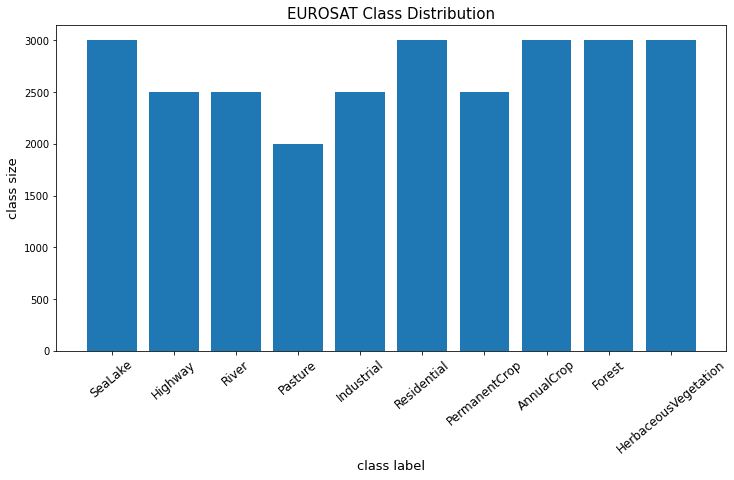

In [3]:
# plot class distributions of whole dataset
counts = {}

for l in LABELS:
    counts[l] = len(os.listdir(os.path.join(DATASET, l)))

    
plt.figure(figsize=(12, 6))

plt.bar(range(len(counts)), list(counts.values()), align='center')
plt.xticks(range(len(counts)), list(counts.keys()), fontsize=12, rotation=40)
plt.xlabel('class label', fontsize=13)
plt.ylabel('class size', fontsize=13)
plt.title('EUROSAT Class Distribution', fontsize=15);

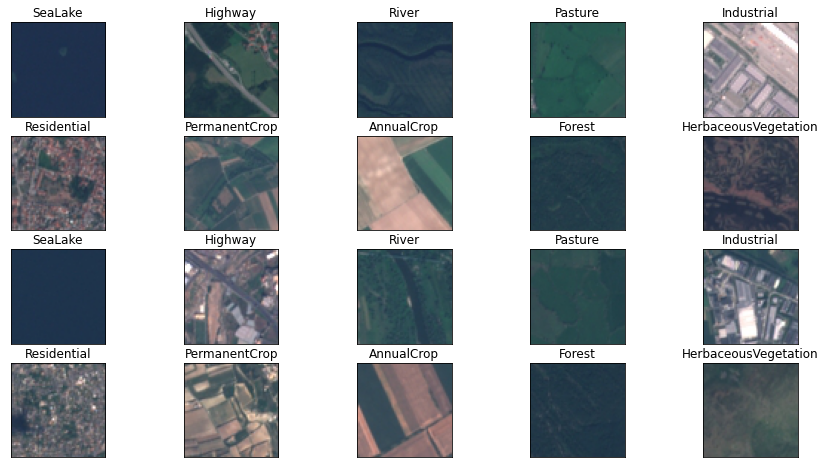

In [4]:
img_paths = [os.path.join(DATASET, l, l+'_1000.jpg') for l in LABELS]

img_paths = img_paths + [os.path.join(DATASET, l, l+'_2000.jpg') for l in LABELS]

def plot_sat_imgs(paths):
    plt.figure(figsize=(15, 8))
    for i in range(20):
        plt.subplot(4, 5, i+1, xticks=[], yticks=[])
        img = PIL.Image.open(paths[i], 'r')
        plt.imshow(np.asarray(img))
        plt.title(paths[i].split('/')[-2])

plot_sat_imgs(img_paths)

In [5]:
import re
from sklearn.model_selection import StratifiedShuffleSplit
from keras.preprocessing.image import ImageDataGenerator

TRAIN_DIR = '../working/training'
TEST_DIR = '../working/testing'
BATCH_SIZE = 64
NUM_CLASSES=len(LABELS)
INPUT_SHAPE = (64, 64, 3)
CLASS_MODE = 'categorical'
for path in (TRAIN_DIR, TEST_DIR):
    if not os.path.exists(path):
        os.mkdir(path)
for l in LABELS:
    
    if not os.path.exists(os.path.join(TRAIN_DIR, l)):
        os.mkdir(os.path.join(TRAIN_DIR, l))

    if not os.path.exists(os.path.join(TEST_DIR, l)):
        os.mkdir(os.path.join(TEST_DIR, l))

Using TensorFlow backend.


In [6]:
data = {}

for l in LABELS:
    for img in os.listdir(DATASET+'/'+l):
        data.update({os.path.join(DATASET, l, img): l})

X = pd.Series(list(data.keys()))
y = pd.get_dummies(pd.Series(data.values()))

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=69)
for train_idx, test_idx in split.split(X, y):
    
    train_paths = X[train_idx]
    test_paths = X[test_idx]
    new_train_paths = [re.sub('\.\.\/input\/2750', '../working/training', i) for i in train_paths]
    new_test_paths = [re.sub('\.\.\/input\/2750', '../working/testing', i) for i in test_paths]

    train_path_map = list((zip(train_paths, new_train_paths)))
    test_path_map = list((zip(test_paths, new_test_paths)))
    print("moving training files..")
    for i in tqdm(train_path_map):
        if not os.path.exists(i[1]):
            if not os.path.exists(re.sub('training', 'testing', i[1])):
                shutil.copy(i[0], i[1])
    
    print("moving testing files..")
    for i in tqdm(test_path_map):
        if not os.path.exists(i[1]):
            if not os.path.exists(re.sub('training', 'testing', i[1])):
                shutil.copy(i[0], i[1])

  0%|          | 16/21600 [00:00<02:18, 155.41it/s]

moving training files..


  0%|          | 13/5400 [00:00<00:42, 128.14it/s]

moving testing files..


100%|██████████| 5400/5400 [00:41<00:00, 129.15it/s]


In [7]:
train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=60,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip = True
#   validation_split=0.2
)

train_generator = train_gen.flow_from_directory(
    directory=TRAIN_DIR,
    target_size=(64, 64),
    batch_size=BATCH_SIZE,
    class_mode=CLASS_MODE,
    #subset='training',
    color_mode='rgb',
    shuffle=True,
    seed=69
)
test_gen = ImageDataGenerator(
    rescale=1./255,
)

test_generator = test_gen.flow_from_directory(
    directory=TEST_DIR,
    target_size=(64, 64),
    batch_size=BATCH_SIZE,
    class_mode=CLASS_MODE,
    color_mode='rgb',
    shuffle=False,
    seed=69
)

Found 21600 images belonging to 10 classes.
Found 5400 images belonging to 10 classes.


In [8]:
print(train_generator.class_indices)

{'AnnualCrop': 0, 'Forest': 1, 'HerbaceousVegetation': 2, 'Highway': 3, 'Industrial': 4, 'Pasture': 5, 'PermanentCrop': 6, 'Residential': 7, 'River': 8, 'SeaLake': 9}


In [9]:
np.save('class_indices', train_generator.class_indices)

In [10]:
rf_gen = ImageDataGenerator(rescale=1./255)

rf_train_generator = rf_gen.flow_from_directory(
    directory=TRAIN_DIR,
    target_size=(64, 64),
    batch_size=21600, 
    class_mode=CLASS_MODE,
    color_mode='rgb',
    shuffle=False,
    seed=7
)

rf_test_generator = rf_gen.flow_from_directory(
    directory=TEST_DIR,
    target_size=(64, 64),
    batch_size=5400,
    class_mode=CLASS_MODE,
    color_mode='rgb',
    shuffle=False,
    seed=7
)

Found 21600 images belonging to 10 classes.
Found 5400 images belonging to 10 classes.


In [11]:
TEST_DIR

'../working/testing'

In [12]:
train = rf_train_generator.next()
X_train = train[0].reshape(21600, 12288)
y_train = train[1]

test = rf_test_generator.next()
X_test = test[0].reshape(5400, 12288)
y_test = test[1]

### 1. Random Forest Scikit-Learn Implementation

In [13]:
ids_1 = np.random.choice(len(X_train), size=21600, replace=False)
X_train_mini_1 = X_train[ids_1]
y_train_mini_1 = rf_train_generator.classes[ids_1]

In [18]:
# import random forest classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score


rf_clf = RandomForestClassifier(n_estimators=20, n_jobs=-1, random_state=7)
rf_clf.fit(X_train_mini_1, y_train_mini_1)
y_pred = rf_clf.predict(X_test)
acc = accuracy_score(y_pred, rf_test_generator.classes)
print("Accuracy Score: {0:.4}".format(acc))

Accuracy Score: 0.6228


In [11]:
import tensorflow as tf
from keras.models import Model
from keras.layers import Dense, Dropout, Flatten
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam


from keras.applications import VGG16, VGG19
from keras.applications import ResNet50, ResNet50V2, ResNet152V2
from keras.applications import InceptionV3, Xception

from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, fbeta_score, accuracy_score

In [12]:
def compile_model(cnn_base, input_shape, n_classes, optimizer, fine_tune=None):
    
    if (cnn_base == 'ResNet50') or (cnn_base == 'ResNet50V2') or (cnn_base == 'ResNet152V2'):
        if cnn_base == 'ResNet50':
            conv_base = ResNet50(include_top=False,
                                 weights='imagenet', 
                                 input_shape=input_shape)
        elif cnn_base == 'ResNet50V2':
            conv_base = ResNet50V2(include_top=False,
                                 weights='imagenet', 
                                 input_shape=input_shape)
        else:
            conv_base = ResNet152V2(include_top=False,
                                 weights='imagenet', 
                                 input_shape=input_shape)
        top_model = conv_base.output
        top_model = Flatten()(top_model)
        top_model = Dense(2048, activation='relu')(top_model)
        top_model = Dropout(0.2)(top_model)
       
    
    elif (cnn_base == 'VGG16') or (cnn_base == 'VGG19'):
        if cnn_base == 'VGG16':
            conv_base = VGG16(include_top=False,
                              weights='imagenet', 
                              input_shape=input_shape)
        else:
            conv_base = VGG19(include_top=False,
                              weights='imagenet', 
                              input_shape=input_shape)
        top_model = conv_base.output
        top_model = Flatten()(top_model)
        top_model = Dense(2048, activation='relu')(top_model)
        top_model = Dropout(0.2)(top_model)
        top_model = Dense(2048, activation='relu')(top_model)
        top_model = Dropout(0.2)(top_model)
    
    
    output_layer = Dense(n_classes, activation='softmax')(top_model)
    
    model = Model(inputs=conv_base.input, outputs=output_layer)
        
    if type(fine_tune) == int:
        for layer in conv_base.layers[fine_tune:]:
            layer.trainable = True
    else:
        for layer in conv_base.layers:
            layer.trainable = False

    model.compile(optimizer=optimizer, loss='categorical_crossentropy',
                 metrics=['categorical_accuracy'])
    
    return model

def plot_history(history):
       
    acc = history.history['categorical_accuracy']
    val_acc = history.history['val_categorical_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(acc)
    plt.plot(val_acc)
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    
    plt.subplot(1, 2, 2)
    plt.plot(loss)
    plt.plot(val_loss)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    
    plt.show();

def display_results(y_true, y_preds, class_labels):
    
    results = pd.DataFrame(precision_recall_fscore_support(y_true, y_preds),
                          columns=class_labels).T
    results.rename(columns={0: 'Precision',
                           1: 'Recall',
                           2: 'F-Score',
                           3: 'Support'}, inplace=True)
    
    conf_mat = pd.DataFrame(confusion_matrix(y_true, y_preds), 
                            columns=class_labels,
                            index=class_labels)    
    f2 = fbeta_score(y_true, y_preds, beta=2, average='micro')
    accuracy = accuracy_score(y_true, y_preds)
    print(f"Accuracy: {accuracy}")
    print(f"Global F2 Score: {f2}")    
    return results, conf_mat

def plot_predictions(y_true, y_preds, test_generator, class_indices):

    fig = plt.figure(figsize=(20, 10))
    for i, idx in enumerate(np.random.choice(test_generator.samples, size=20, replace=False)):
        ax = fig.add_subplot(4, 5, i + 1, xticks=[], yticks=[])
        ax.imshow(np.squeeze(test_generator[idx]))
        pred_idx = np.argmax(y_preds[idx])
        true_idx = y_true[idx]
                
        plt.tight_layout()
        ax.set_title("{}\n({})".format(class_indices[pred_idx], class_indices[true_idx]),
                     color=("green" if pred_idx == true_idx else "red"))    

In [23]:
N_STEPS = train_generator.samples//BATCH_SIZE
N_VAL_STEPS = test_generator.samples//BATCH_SIZE
N_EPOCHS = 100

# model callbacks
checkpoint = ModelCheckpoint(filepath='../working/model.weights.best.hdf5',
                        monitor='val_categorical_accuracy',
                        save_best_only=True,
                        verbose=1)

early_stop = EarlyStopping(monitor='val_categorical_accuracy',
                           patience=10,
                           restore_best_weights=True,
                           mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5,
                              patience=3, min_lr=0.00001)

In [14]:
vgg16 = compile_model('VGG16', INPUT_SHAPE, NUM_CLASSES, Adam(lr=1e-2), fine_tune=None)
vgg16.summary()

58892288/58889256 [==============================] - 0s 0us/step
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
____________________________________________________________

In [19]:
train_generator.reset()
test_generator.reset()

N_STEPS = train_generator.samples//BATCH_SIZE
N_VAL_STEPS = test_generator.samples//BATCH_SIZE
N_EPOCHS = 50

# model callbacks
checkpoint = ModelCheckpoint(filepath='../working/model.weights.best.hdf5',
                        monitor='val_categorical_accuracy',
                        save_best_only=True,
                        verbose=1)

early_stop = EarlyStopping(monitor='val_categorical_accuracy',
                           patience=10,
                           restore_best_weights=True,
                           mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5,
                              patience=3, min_lr=0.00001)

In [17]:
train_generator.reset()
# First Pretraining the dense layer
vgg16_history = vgg16.fit_generator(train_generator,
                             steps_per_epoch=N_STEPS,
                             epochs=30,
                             callbacks=[early_stop, checkpoint],
                             validation_data=test_generator,
                             validation_steps=N_VAL_STEPS)

Epoch 1/30
337/337 [==============================] - 40s 118ms/step - loss: 2.0338 - categorical_accuracy: 0.5339 - val_loss: 0.4798 - val_categorical_accuracy: 0.7223

Epoch 00001: val_categorical_accuracy improved from -inf to 0.72228, saving model to ../working/model.weights.best.hdf5
Epoch 2/30
337/337 [==============================] - 36s 107ms/step - loss: 1.0971 - categorical_accuracy: 0.6280 - val_loss: 0.2847 - val_categorical_accuracy: 0.7305

Epoch 00002: val_categorical_accuracy improved from 0.72228 to 0.73051, saving model to ../working/model.weights.best.hdf5
Epoch 3/30
337/337 [==============================] - 35s 105ms/step - loss: 1.0525 - categorical_accuracy: 0.6500 - val_loss: 0.3863 - val_categorical_accuracy: 0.7123

Epoch 00003: val_categorical_accuracy did not improve from 0.73051
Epoch 4/30
337/337 [==============================] - 36s 106ms/step - loss: 1.0075 - categorical_accuracy: 0.6625 - val_loss: 0.8812 - val_categorical_accuracy: 0.7296

Epoch 0000

In [20]:
# re-train whole network end2end 
vgg16 = compile_model('VGG16', INPUT_SHAPE, NUM_CLASSES, Adam(lr=1e-4), fine_tune=0)

vgg16.load_weights('../working/model.weights.best.hdf5')

train_generator.reset()
test_generator.reset()

vgg16_history = vgg16.fit_generator(train_generator,
                             steps_per_epoch=N_STEPS,
                             epochs=N_EPOCHS,
                             callbacks=[early_stop, checkpoint, reduce_lr],
                             validation_data=test_generator,
                             validation_steps=N_VAL_STEPS)

Epoch 1/50
337/337 [==============================] - 38s 113ms/step - loss: 1.4519 - categorical_accuracy: 0.5122 - val_loss: 0.1979 - val_categorical_accuracy: 0.5759

Epoch 00001: val_categorical_accuracy improved from -inf to 0.57589, saving model to ../working/model.weights.best.hdf5
Epoch 2/50
337/337 [==============================] - 37s 110ms/step - loss: 0.9547 - categorical_accuracy: 0.6820 - val_loss: 0.0782 - val_categorical_accuracy: 0.7524

Epoch 00002: val_categorical_accuracy improved from 0.57589 to 0.75244, saving model to ../working/model.weights.best.hdf5
Epoch 3/50
337/337 [==============================] - 37s 110ms/step - loss: 0.6526 - categorical_accuracy: 0.8040 - val_loss: 0.3339 - val_categorical_accuracy: 0.7910

Epoch 00003: val_categorical_accuracy improved from 0.75244 to 0.79104, saving model to ../working/model.weights.best.hdf5
Epoch 4/50
337/337 [==============================] - 38s 112ms/step - loss: 0.5533 - categorical_accuracy: 0.8416 - val_los

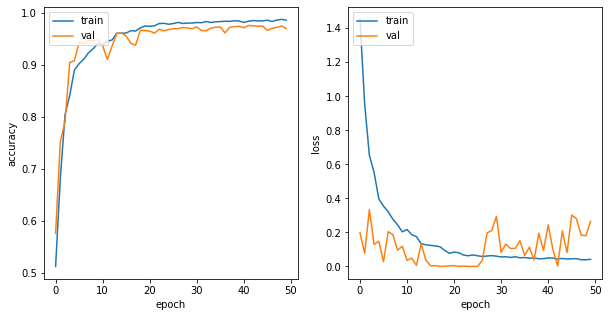

In [21]:
plot_history(vgg16_history)

In [24]:
vgg16.load_weights('../working/model.weights.best.hdf5')

class_indices = train_generator.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())

test_generator_new = test_gen.flow_from_directory(
    directory=TEST_DIR,
    target_size=(64, 64),
    batch_size=1,
    class_mode=None,
    color_mode='rgb',
    shuffle=False,
    seed=69
)

predictions = vgg16.predict_generator(test_generator_new, steps=len(test_generator_new.filenames))
predicted_classes = np.argmax(np.rint(predictions), axis=1)
true_classes = test_generator_new.classes

prf, conf_mat = display_results(true_classes, predicted_classes, class_indices.values())
prf

Found 5400 images belonging to 10 classes.
Accuracy: 0.9761111111111112
Global F2 Score: 0.976111111111111


,Precision,Recall,F-Score,Support
AnnualCrop,0.978618,0.947452,0.962783,628.0
Forest,0.981997,0.995025,0.988468,603.0
HerbaceousVegetation,0.972077,0.957045,0.964502,582.0
Highway,0.986767,0.970260,0.978444,538.0
Industrial,0.989605,0.967480,0.978417,492.0
Pasture,0.963731,0.984127,0.973822,378.0
PermanentCrop,0.937120,0.962500,0.949640,480.0
Residential,0.972561,0.998435,0.985328,639.0
River,0.978261,0.988024,0.983118,501.0
SeaLake,0.994614,0.991055,0.992832,559.0


In [27]:
# Save the model and the weights
vgg16.save('../working/vgg16_eurosat.h5')

## 4.5 VGG19 Model

In [28]:
vgg19 = compile_model('VGG19', INPUT_SHAPE, NUM_CLASSES, Adam(lr=1e-2), fine_tune=None)
vgg19.summary()

80142336/80134624 [==============================] - 0s 0us/step
Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
____________________________________________________________

In [31]:
train_generator.reset()
test_generator.reset()

N_STEPS = train_generator.samples//BATCH_SIZE
N_VAL_STEPS = test_generator.samples//BATCH_SIZE
N_EPOCHS = 50

# model callbacks
checkpoint = ModelCheckpoint(filepath='../working/model.weights.best.hdf5',
                        monitor='val_categorical_accuracy',
                        save_best_only=True,
                        verbose=1)

early_stop = EarlyStopping(monitor='val_categorical_accuracy',
                           patience=10,
                           restore_best_weights=True,
                           mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5,
                              patience=3, min_lr=0.00001)

In [30]:
train_generator.reset()
vgg19_history = vgg19.fit_generator(train_generator,
                             steps_per_epoch=N_STEPS,
                             epochs=50,
                             callbacks=[early_stop, checkpoint],
                             validation_data=test_generator,
                             validation_steps=N_VAL_STEPS)

Epoch 1/50
337/337 [==============================] - 37s 108ms/step - loss: 2.2369 - categorical_accuracy: 0.5084 - val_loss: 0.3063 - val_categorical_accuracy: 0.6384

Epoch 00001: val_categorical_accuracy improved from -inf to 0.63839, saving model to ../working/model.weights.best.hdf5
Epoch 2/50
337/337 [==============================] - 36s 107ms/step - loss: 1.1988 - categorical_accuracy: 0.5809 - val_loss: 0.5796 - val_categorical_accuracy: 0.6645

Epoch 00002: val_categorical_accuracy improved from 0.63839 to 0.66454, saving model to ../working/model.weights.best.hdf5
Epoch 3/50
337/337 [==============================] - 37s 108ms/step - loss: 1.1543 - categorical_accuracy: 0.5949 - val_loss: 0.3827 - val_categorical_accuracy: 0.6447

Epoch 00003: val_categorical_accuracy did not improve from 0.66454
Epoch 4/50
337/337 [==============================] - 36s 106ms/step - loss: 1.1610 - categorical_accuracy: 0.5989 - val_loss: 0.4060 - val_categorical_accuracy: 0.6464

Epoch 0000

In [33]:
vgg19 = compile_model('VGG19', INPUT_SHAPE, NUM_CLASSES, Adam(lr=1e-4), fine_tune=0)

vgg19 .load_weights('../working/model.weights.best.hdf5')

train_generator.reset()
test_generator.reset()

vgg19_history = vgg19.fit_generator(train_generator,
                             steps_per_epoch=N_STEPS,
                             epochs=N_EPOCHS,
                             callbacks=[early_stop, checkpoint, reduce_lr],
                             validation_data=test_generator,
                             validation_steps=N_VAL_STEPS)

Epoch 1/50
337/337 [==============================] - 44s 131ms/step - loss: 2.2366 - categorical_accuracy: 0.2679 - val_loss: 2.7023 - val_categorical_accuracy: 0.3350

Epoch 00001: val_categorical_accuracy improved from -inf to 0.33501, saving model to ../working/model.weights.best.hdf5
Epoch 2/50
337/337 [==============================] - 43s 127ms/step - loss: 1.6828 - categorical_accuracy: 0.3760 - val_loss: 1.6418 - val_categorical_accuracy: 0.5690

Epoch 00002: val_categorical_accuracy improved from 0.33501 to 0.56897, saving model to ../working/model.weights.best.hdf5
Epoch 3/50
337/337 [==============================] - 43s 128ms/step - loss: 1.1726 - categorical_accuracy: 0.5660 - val_loss: 1.2755 - val_categorical_accuracy: 0.4891

Epoch 00003: val_categorical_accuracy did not improve from 0.56897
Epoch 4/50
337/337 [==============================] - 43s 128ms/step - loss: 0.8369 - categorical_accuracy: 0.7102 - val_loss: 0.5357 - val_categorical_accuracy: 0.7826

Epoch 0000

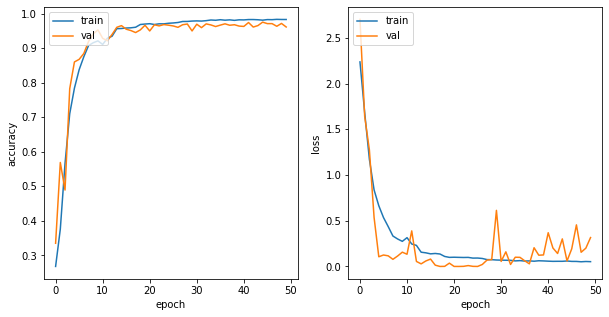

In [34]:
plot_history(vgg19_history)

In [36]:
vgg19.load_weights('../working/model.weights.best.hdf5')

class_indices = train_generator.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())

test_generator_new = test_gen.flow_from_directory(
    directory=TEST_DIR,
    target_size=(64, 64),
    batch_size=1,
    class_mode=None,
    color_mode='rgb',
    shuffle=False,
    seed=69
)

predictions = vgg19.predict_generator(test_generator_new, steps=len(test_generator_new.filenames))
predicted_classes = np.argmax(np.rint(predictions), axis=1)
true_classes = test_generator_new.classes

prf, conf_mat = display_results(true_classes, predicted_classes, class_indices.values())
prf

Found 5400 images belonging to 10 classes.
Accuracy: 0.9746296296296296
Global F2 Score: 0.9746296296296295


,Precision,Recall,F-Score,Support
AnnualCrop,0.971154,0.964968,0.968051,628.0
Forest,0.972492,0.996683,0.984439,603.0
HerbaceousVegetation,0.989286,0.951890,0.970228,582.0
Highway,0.981308,0.975836,0.978565,538.0
Industrial,0.967280,0.961382,0.964322,492.0
Pasture,0.973753,0.981481,0.977602,378.0
PermanentCrop,0.954451,0.960417,0.957425,480.0
Residential,0.957958,0.998435,0.977778,639.0
River,0.980237,0.990020,0.985104,501.0
SeaLake,1.000000,0.962433,0.980857,559.0


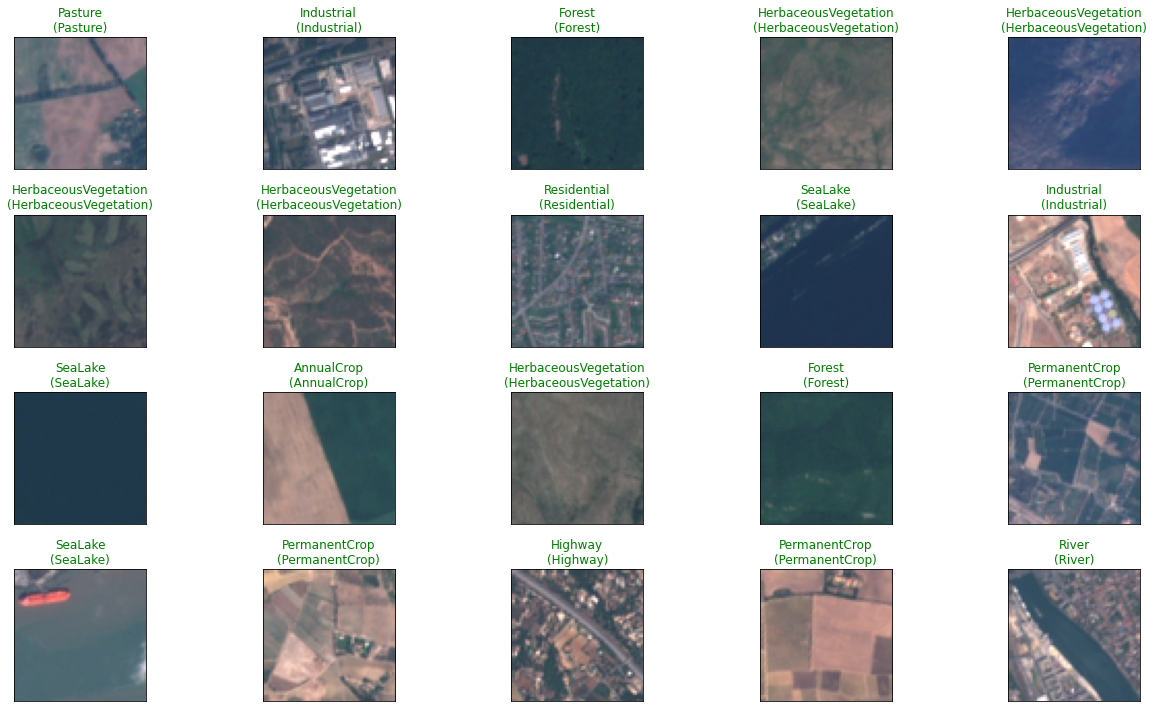

In [37]:
plot_predictions(true_classes, predictions, test_generator_new, class_indices)

In [39]:
# Save the model and the weights
vgg19.save('../working/vgg19.h5')